In [4]:
!pip install scikit-image

In [5]:
dataset_path = "/Users/nishantdalal/Downloads/data"

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from skimage.feature import hog

In [7]:
def extract_features(img):
    img_resized = cv2.resize(img, (64, 64))

    hu = cv2.HuMoments(cv2.moments(img_resized)).flatten()
    hog_features = hog(img_resized,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys',
                       visualize=False)

    return np.concatenate([hu, hog_features])

In [8]:
def load_images_with_features(folder, label):
    data, labels = [], []
    for filename in tqdm(os.listdir(folder), desc=f"Processing {label}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            features = extract_features(img)
            data.append(features)
            labels.append(label)
    return data, labels

forged_path = os.path.join(dataset_path, 'forged')
genuine_path = os.path.join(dataset_path, 'genuine')

forged_data, forged_labels = load_images_with_features(forged_path, 0)
genuine_data, genuine_labels = load_images_with_features(genuine_path, 1)

X = np.array(forged_data + genuine_data)
y = np.array(forged_labels + genuine_labels)

print("Dataset Loaded. Total Samples:", X.shape[0], " | Feature Length:", X.shape[1])

Processing 1: 100%|██████████| 145/145 [00:00<00:00, 466.85it/s]

Dataset Loaded. Total Samples: 290  | Feature Length: 1771


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import time

# Define hyperparameters
params = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

total_combos = len(params['C']) * len(params['gamma']) * len(params['kernel'])

print("Starting Grid Search...")
print(f"Total combinations to try: {total_combos}")
print(f"Expected fits (with 3-fold CV): {total_combos * 3}\n")

start_time = time.time()

# Grid Search with cross-validation
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    cv=3,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

grid.fit(X_train_scaled, y_train)

end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60

print(f"\nGrid Search Complete in {elapsed_minutes:.2f} minutes.")
print("Best Parameters:", grid.best_params_)

# Best model
svm_best = grid.best_estimator_

# Results DataFrame
results_df = pd.DataFrame(grid.cv_results_)
results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)

print("\n📊 Top 5 Configurations:")
try:
    from IPython.display import display
    display(results_df_sorted[['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'mean_train_score']].head(5))
except ImportError:
    print(results_df_sorted[['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'mean_train_score']].head(5))

Starting Grid Search...
Total combinations to try: 18
Expected fits (with 3-fold CV): 54

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......................C=1, ga

,param_C,param_gamma,param_kernel,mean_test_score,mean_train_score
6,10,scale,rbf,0.931013,1.0
12,100,scale,rbf,0.931013,1.0
10,10,0.001,rbf,0.918082,1.0
16,100,0.001,rbf,0.918082,1.0
4,1,0.001,rbf,0.918082,1.0


In [11]:
y_pred = svm_best.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Forged", "Genuine"]))

Confusion Matrix:
 [[28  0]
 [ 3 27]]

Classification Report:
              precision    recall  f1-score   support

      Forged       0.90      1.00      0.95        28
     Genuine       1.00      0.90      0.95        30

    accuracy                           0.95        58
   macro avg       0.95      0.95      0.95        58
weighted avg       0.95      0.95      0.95        58



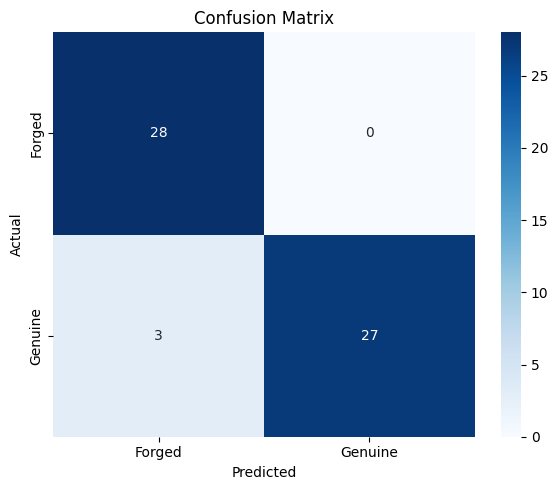

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Forged", "Genuine"],
            yticklabels=["Forged", "Genuine"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [13]:
import joblib

In [16]:
joblib.dump(svm_best, "model1.pkl")

['model1.pkl']

In [15]:
joblib.dump(scaler, "scaler1.pkl")

['scaler1.pkl']